In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
import pandas
import matplotlib.pylab as plt
import os
import glob
import skillsnetwork

import torch
from torch.utils.data import Dataset
import skillsnetwork 

In [2]:
def show_data(data_sample, shape = (28, 28)):
    plt.imshow(data_sample[0].numpy().reshape(shape), cmap='gray')
    plt.title('y = ' + data_sample[1])

In [3]:

await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to 'resources/data'


In [4]:
directory="resources/data"
negative='Negative'

negative_file_path=os.path.join(directory,negative)
negative_file_path
os.listdir(negative_file_path)[0:3]
[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path)][0:3]

print("test.jpg".endswith(".jpg"))
print("test.mpg".endswith(".jpg"))

negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
negative_files.sort()
negative_files[0:3]

True
False


['resources/data/Negative/00001.jpg',
 'resources/data/Negative/00002.jpg',
 'resources/data/Negative/00003.jpg']

In [5]:
positive="Positive"

positive_file_path=os.path.join(directory,positive)
positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
os.listdir(positive_file_path)[0:3]
[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path)][0:3]

positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
positive_files.sort()
positive_files[0:3]

['resources/data/Positive/00001.jpg',
 'resources/data/Positive/00002.jpg',
 'resources/data/Positive/00003.jpg']

In [6]:
image1 = Image.open(negative_files[0])

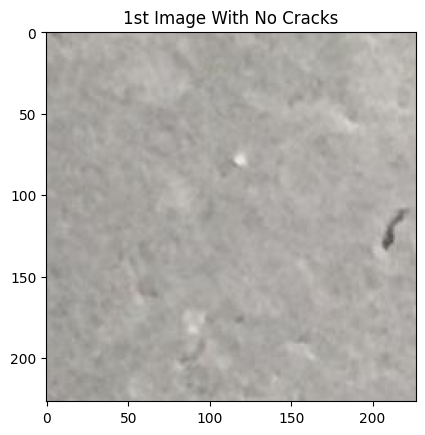

In [7]:
plt.imshow(image1)
plt.title("1st Image With No Cracks")
plt.show()

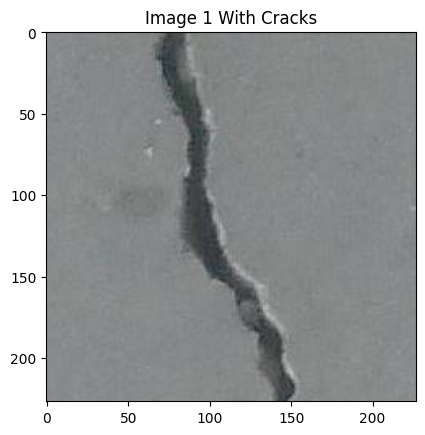

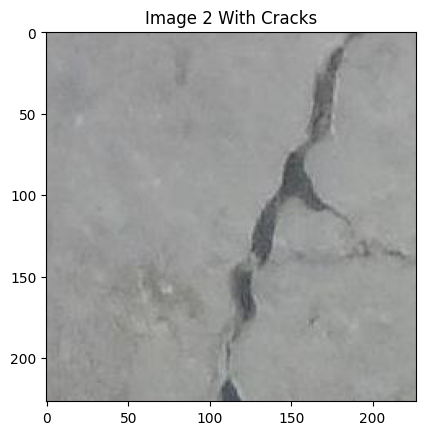

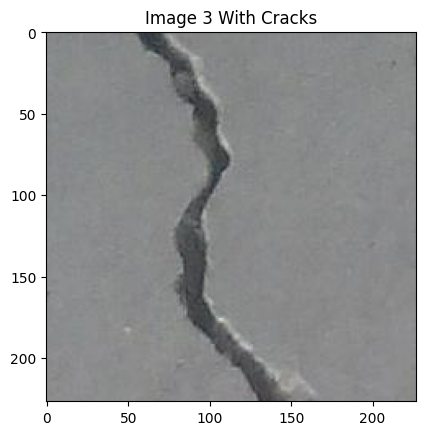

In [8]:
for i in range(3):
    image = Image.open(positive_files[i])
    plt.imshow(image)
    plt.title(f"Image {i+1} With Cracks")
    plt.show()

In [9]:
number_of_samples = len(positive_files) + len(negative_files)
number_of_samples

40000

In [10]:
Y=torch.zeros([number_of_samples])
Y=Y.type(torch.LongTensor)
Y.type()
Y[::2]=1
Y[1::2]=0

In [11]:
# Create the all_files list
all_files = [None] * number_of_samples
all_files[::2] = positive_files
all_files[1::2] = negative_files

# Print the first four samples
for i in range(4):
    print(all_files[i])

resources/data/Positive/00001.jpg
resources/data/Negative/00001.jpg
resources/data/Positive/00002.jpg
resources/data/Negative/00002.jpg


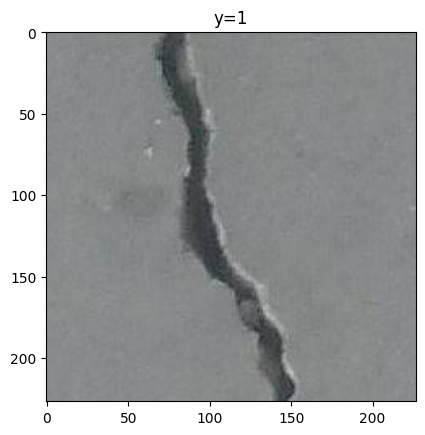

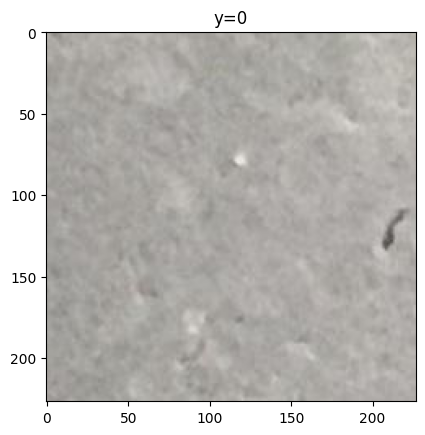

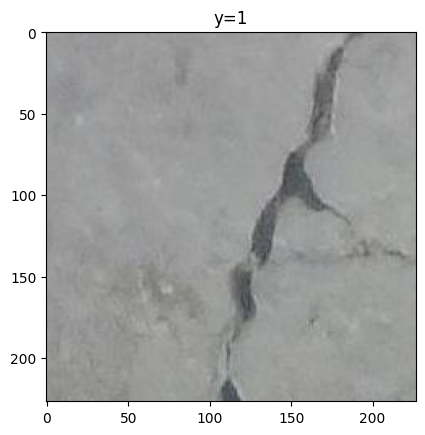

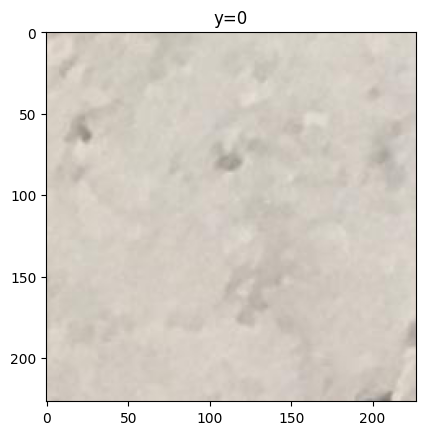

In [12]:
for y,file in zip(Y, all_files[0:4]):
    plt.imshow(Image.open(file))
    plt.title("y="+str(y.item()))
    plt.show()

In [13]:
train=False

if train:
    all_files=all_files[0:30000]
    Y=Y[0:30000]

else:
    all_files=all_files[30000:]
    Y=Y[30000:]

In [17]:
if train:
    all_files = all_files[:30000]
else:
    all_files = all_files[30000:]

# Print the first four validation sample images
for file in all_files[:4]:
    plt.imshow(Image.open(file))
    plt.title(f"Validation Image: {file}")
    plt.show()

In [15]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:

            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:

            self.Y=self.Y[30000:]
            self.len=len(self.all_files)
    
  
            
     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [ ]:
# Create the Dataset object for training data
dataset = Dataset(train=True)

# Print the 10th sample
sample_10 = dataset[9]
plt.imshow(sample_10[0])
plt.xlabel("y=" + str(sample_10[1].item()))
plt.title("Training data, sample 10")
plt.show()

# Print the 100th sample
sample_100 = dataset[99]
plt.imshow(sample_100[0])
plt.xlabel("y=" + str(sample_100[1].item()))
plt.title("Training data, sample 100")
plt.show()

In [16]:
for sample  in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

NameError: name 'samples' is not defined

In [ ]:
# Create the Dataset object for validation data
validation_dataset = Dataset(train=False)

# Print the 16th sample
sample_16 = validation_dataset[15]
plt.imshow(sample_16[0])
plt.xlabel("y=" + str(sample_16[1].item()))
plt.title("Validation data, sample 16")
plt.show()

# Print the 103rd sample
sample_103 = validation_dataset[102]
plt.imshow(sample_103[0])
plt.xlabel("y=" + str(sample_103[1].item()))
plt.title("Validation data, sample 103")
plt.show()